In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tf_explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00


In [3]:
import cv2
import os
import glob
from tqdm import tqdm
import numpy as np
#np.random.seed = 42
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.utils import plot_model
from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
root_dir = '/content/drive/MyDrive/input/Dataset_BUSI_with_GT'
os.listdir(root_dir)

['.DS_Store', 'malignant', 'normal', 'benign']

In [5]:
IMG_WIDTH = 128
IMG_HIGH = 128
IMG_CHANNELS = 3 # number of input channels

In [7]:
def LoadData(root_dir, FolderName, img_width=IMG_WIDTH, img_high=IMG_HIGH, img_channels=IMG_CHANNELS):
  num_samples = 0
  
  for address in glob.glob(root_dir + f'/{FolderName}/*'):
    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')
    if len(s_address) == 1:
      num_samples += 1

  X = np.zeros((num_samples, img_high, img_width, img_channels), dtype=np.uint8)
  Y = np.zeros((num_samples, img_high, img_width, 1), dtype=np.bool8)

  
  for address in tqdm(glob.glob(root_dir + f'/{FolderName}/*')):
    img = cv2.imread(address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (img_width, img_high), interpolation=cv2.INTER_CUBIC)
    
    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')
    idx = s_address[0]
    idx = int(idx.split('(')[1].split(')')[0]) - 1
    
    if len(s_address) == 1:
      X[idx] = resized_image
      
    elif len(s_address) > 1:
      mask = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
      
      mask = np.expand_dims(mask, axis=-1)
      Y[idx] = np.maximum(mask, Y[idx])

  return X, Y

In [8]:
x_benign, y_benign = LoadData(root_dir, 'benign')
x_malignant, y_malignant = LoadData(root_dir, 'malignant')
x_normal, y_normal = LoadData(root_dir, 'normal')


100%|██████████| 266/266 [00:07<00:00, 35.20it/s]


In [11]:
print(x_benign.shape, y_benign.shape, type(x_benign), type(x_benign))
print(x_malignant.shape, y_malignant.shape, type(x_malignant), type(y_malignant))
print(x_normal.shape, y_normal.shape, type(x_normal), type(y_normal))

(437, 128, 128, 3) (437, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(215, 128, 128, 3) (215, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(133, 128, 128, 3) (133, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [12]:
X = np.concatenate((x_benign, x_malignant, x_normal), axis=0)
y = np.concatenate((y_benign, y_malignant, y_normal), axis=0)

In [13]:
X_norm = X / 255
y_norm = y / 255

In [14]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                 y, 
                                 test_size=0.1,
                                 random_state=11,
                                 shuffle=True
                                 )
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                            y_train_val,
                            test_size=0.1,
                            random_state=11,
                            shuffle=True
                            )

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((635, 128, 128, 3),
 (635, 128, 128, 1),
 (71, 128, 128, 3),
 (71, 128, 128, 1),
 (79, 128, 128, 3),
 (79, 128, 128, 1))

In [18]:
# RGB transform Gray
X_train = tf.image.rgb_to_grayscale(X_train)
X_test = tf.image.rgb_to_grayscale(X_test)
X_val = tf.image.rgb_to_grayscale(X_val)
type(X_train)
#Out[85]: tensorflow.python.framework.ops.EagerTensor
print(X_train.shape, X_test.shape, X_val.shape)
#(439, 224, 224, 1) (236, 224, 224, 1) (110, 224, 224, 1)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
type(X_train)
#Out[87]: numpy.ndarray

(635, 128, 128, 1) (79, 128, 128, 1) (71, 128, 128, 1)


numpy.ndarray

In [15]:
from tensorflow import keras
import tensorflow as tf
from keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, Concatenate, MaxPooling2D, BatchNormalization, Activation

In [22]:
#attention block
def attention(g, s, num_filters):
  att_g = Conv2D(num_filters, 1, padding="same")(g)
  att_g = BatchNormalization()(att_g)

  att_s = Conv2D(num_filters, 1, padding="same")(s)
  att_s = BatchNormalization()(att_s)

  out = Activation("relu")(att_g + att_s)
  out = Conv2D(num_filters, 1, padding="same")(out)
  out =Activation("sigmoid")(out)

  return out * s 

In [23]:

def build_model():
      inply = Input((X_train.shape[1], X_train.shape[2], X_train.shape[3],))
      conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inply)
      conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
      pool1 = MaxPooling2D((2, 2), strides=2, padding='same')(conv1)
      drop1 = Dropout(0.2)(pool1)

      conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop1)
      conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
      pool2 = MaxPooling2D((2, 2), strides=2, padding='same')(conv2)
      drop2 = Dropout(0.2)(pool2)

      conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop2)
      conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
      pool3 = MaxPooling2D((2, 2), strides=2, padding='same')(conv3)
      drop3 = Dropout(0.2)(pool3)

      conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop3)
      conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
      pool4 = MaxPooling2D((2, 2), strides=2, padding='same')(conv4)
      drop4 = Dropout(0.2)(pool4)

      convm = Conv2D(1024, (3,3), activation='relu', padding='same')(drop4)
      convm = Conv2D(1024, (3,3), activation='relu', padding='same')(convm)

      tran5 = Conv2DTranspose(512, (2, 2), strides=2, padding='valid',
                              activation='relu')(convm)
  
      conc5 = Concatenate()([tran5, conv4])
      conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc5)
      conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
      drop5 = Dropout(0.1)(conv5)

      tran6 = Conv2DTranspose(256, (2, 2), strides=2, padding='valid', activation='relu')(drop5)

      att1 = attention(tran6, conv3, 256)

      conc6 = Concatenate()([tran6, att1])
      conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc6)
      conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
      drop6 = Dropout(0.1)(conv6)

      tran7 = Conv2DTranspose(128, (2, 2), strides=2, padding='valid', activation='relu')(drop6)

      att2 = attention(tran7, conv2, 128)
      
      conc7 = Concatenate()([tran7, att2])
      conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc7)
      conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
      drop7 = Dropout(0.1)(conv7)

      tran8 = Conv2DTranspose(64, (2, 2), strides=2, padding='valid', activation='relu')(drop7)

      att3 = attention(tran8, conv1, 64)

      conc8 = Concatenate()([tran8, att3])
      conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc8)
      conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

      conv8 = BatchNormalization(axis=3)(conv8)
      conv8 = Activation('relu')(conv8)
      drop8 = Dropout(0.1)(conv8)

      outly = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(drop8)
      model = Model(inputs=inply, outputs=outly, name='U-net')
      return model
model = build_model()
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_28[0][0]']              
                                )                                                             

In [24]:
def dice_coef(y_test, y_pred):
  smooth = 1
  y_test_f = K.flatten(y_test)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_test_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_test_f * y_test_f) + K.sum(y_pred_f * y_pred_f) + smooth)

In [25]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0003), loss='binary_crossentropy', metrics=[dice_coef])

In [26]:
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=50)

Epoch 1/50
40/40 [==============================] - 50s 530ms/step - loss: 0.2824 - dice_coef: 0.3505 - val_loss: 0.5422 - val_dice_coef: 0.0917
Epoch 2/50
40/40 [==============================] - 12s 290ms/step - loss: 0.2039 - dice_coef: 0.4729 - val_loss: 0.3648 - val_dice_coef: 0.1262
Epoch 3/50
40/40 [==============================] - 12s 297ms/step - loss: 0.1834 - dice_coef: 0.5338 - val_loss: 0.3218 - val_dice_coef: 0.2011
Epoch 4/50
40/40 [==============================] - 12s 298ms/step - loss: 0.1660 - dice_coef: 0.5833 - val_loss: 0.2852 - val_dice_coef: 0.1940
Epoch 5/50
40/40 [==============================] - 12s 290ms/step - loss: 0.1573 - dice_coef: 0.6068 - val_loss: 0.2036 - val_dice_coef: 0.4375
Epoch 6/50
40/40 [==============================] - 12s 299ms/step - loss: 0.1533 - dice_coef: 0.6200 - val_loss: 0.2103 - val_dice_coef: 0.4071
Epoch 7/50
40/40 [==============================] - 12s 291ms/step - loss: 0.1493 - dice_coef: 0.6289 - val_loss: 0.2565 - val_dic

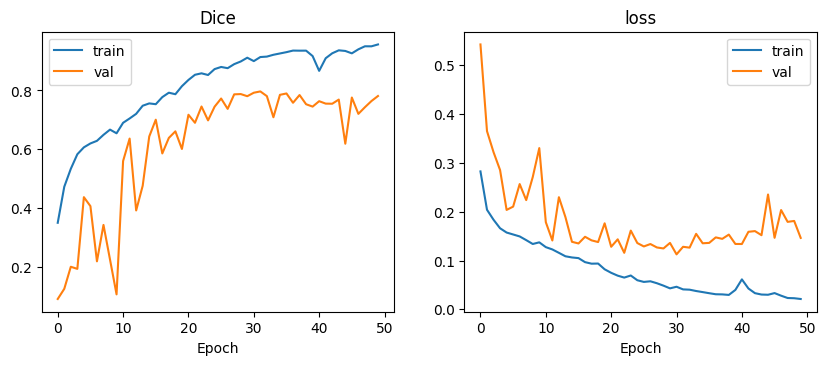

In [27]:
#model_attention_unet
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Dice')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

In [28]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test dice', score[1])

3/3 [==============================] - 7s 1s/step - loss: 0.1769 - dice_coef: 0.8177
Test loss:  0.17689847946166992
Test dice 0.8176958560943604


3/3 [==============================] - 1s 154ms/step


Text(0.5, 1.0, 'image')

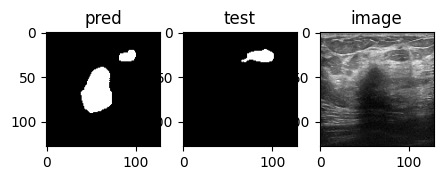

In [29]:
pred = model.predict(X_test)
pred[pred>=0.5]=1
pred[pred<0.5]=0


i=8
plt.figure(figsize=(5, 8))
plt.subplot(1, 3, 1)
plt.imshow(pred[i], cmap='gray')
plt.title("pred")
plt.subplot(1, 3, 2)
plt.imshow(y_test[i], cmap='gray')
plt.title("test")
plt.subplot(1, 3, 3)
plt.imshow(X_test[i], cmap='gray')
plt.title("image")

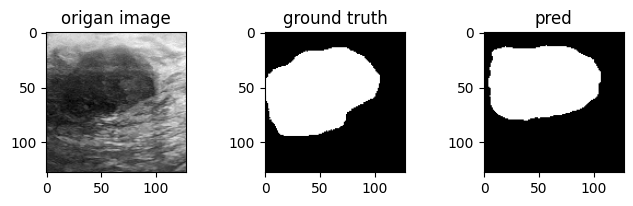

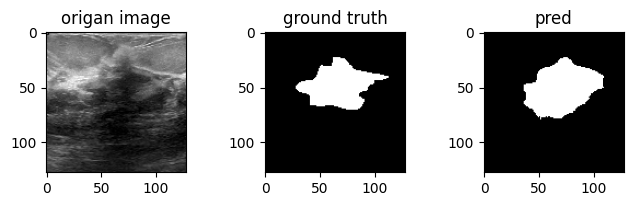

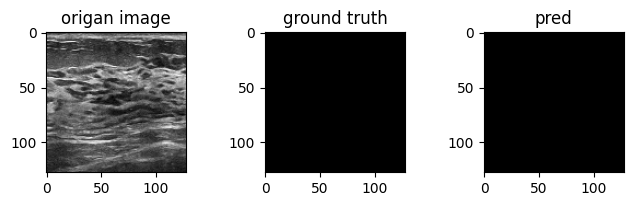

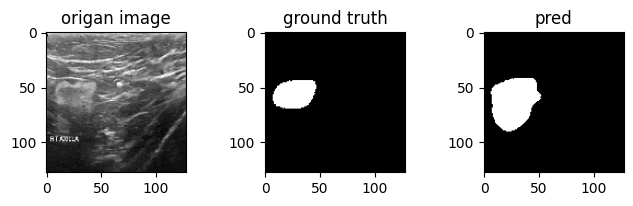

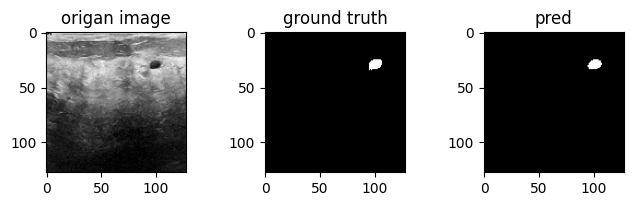

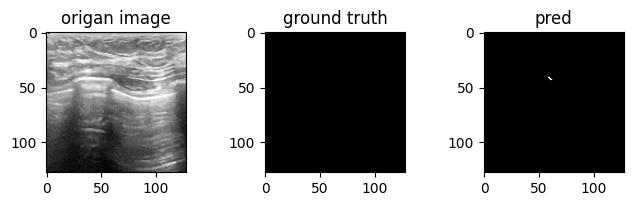

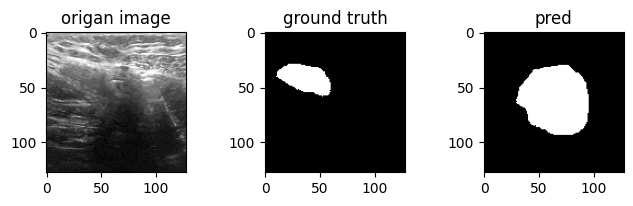

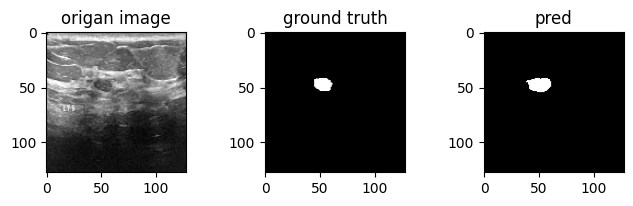

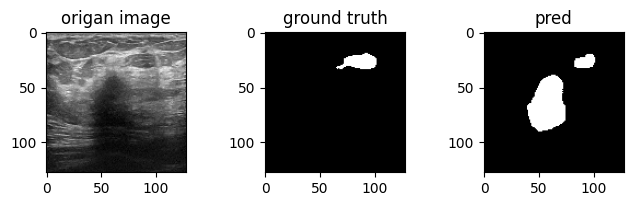

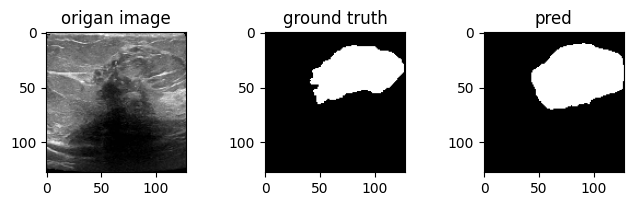

In [30]:
for i in range(10):
  plt.figure(figsize=(8, 4))
  plt.subplot(2, 3, 1)
  plt.title("origan image")
  plt.imshow(X_test[i], cmap='gray')
  plt.subplot(2, 3, 2)
  plt.title("ground truth")
  plt.imshow(y_test[i], cmap='gray')
  plt.subplot(2, 3, 3)
  plt.title("pred")
  plt.imshow(pred[i], cmap='gray')
  plt.show()

In [ ]:
def predict_func(model, image, mask):
  y_pred = model.predict(image[np.newaxis,...])

  exp = GradCAM()
  pred_mask = model.predict(image[np.newaxis,...])
  cam = exp.explain(
      validation_data=(image[np.newaxis,...], mask),
      class_index=1,
      layer_name = model.layers[-1].name,
      model=model
  )

  return y_pred, cam

In [ ]:
for i in range(10):
    id = np.random.randint(len(X_test))
    image = X_test[id]
    mask = y_test[id]
    pred_mask, cam = predict_func(model, image, mask)

    plt.figure(figsize=(13,7))
    plt.subplot(1,3,1)
    plt.title("Original image & mask")
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap='jet', alpha=0.4)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Predicted Mask")
    plt.imshow(image)
    plt.imshow(tf.squeeze(pred_mask), cmap='jet', alpha=0.4)
    plt.axis('off')
  
    plt.subplot(1,3,3)
    plt.title("GradCAM")
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=0.4)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.